In [13]:
%matplotlib inline

In [1]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema
import scipy
from IPython.display import Image
from PIL import Image
from collections import OrderedDict

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [279]:
OUT_PATH = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/test_folder/'

In [280]:
up_match_df = pd.read_csv(os.path.join(OUT_PATH, '20190226_up_match_simple_true_df.csv'), index_col = 0)
down_match_df = pd.read_csv(os.path.join(OUT_PATH, '20190226_down_match_simple_true_df.csv'), index_col = 0)

In [281]:
fn = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/busco3/run_Pst_104E_v13_p_ctg.protein/full_table_Pst_104E_v13_p_ctg.protein.tsv'

p_buscos = pd.read_csv(fn, sep='\t', header=None, comment='#')[2].unique()

In [161]:
fn_effector = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/Pst_104E_v13_ph_ctg.nr_effector.gene.bed'

p_effector = pd.read_csv(fn_effector, sep='\t', header=None, comment='#')[3].unique()

In [234]:
up_match_df['observed_hits'] = up_match_df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)

In [235]:
up_match_df.head()

,0,1,2,3,4,5,6,7,observed_hits,potential_hits
Pst104E_00002,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,8
Pst104E_00005,0.0,0.0,1.0,0.0,1.0,1.0,1.0,NaN,4.0,7
Pst104E_00008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
Pst104E_00013,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,8
Pst104E_00076,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,7.0,8


In [273]:
x_range = list(range(0,8))

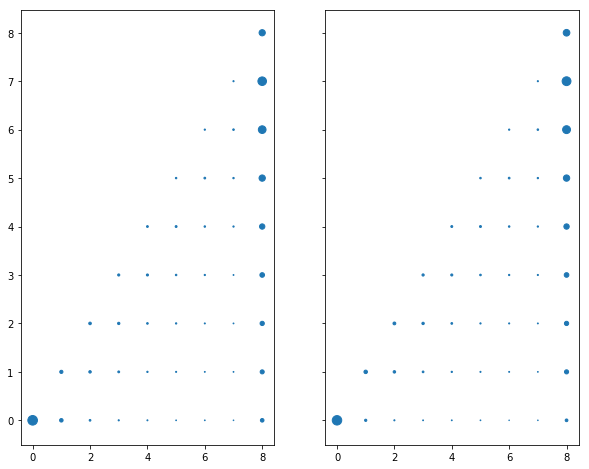

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), sharey=True)
df = up_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax2.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))
df = down_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax1.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))

In [302]:
up_hit_array = up_match_df.iloc[:,0:8].apply(lambda x: np.sum(x))
up_possible_hit_array = up_match_df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)))
down_hit_array = down_match_df.iloc[:,0:8].apply(lambda x: np.sum(x))[::-1]
down_possible_hit_array = down_match_df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)))[::-1]
x_axis_index = np.array(range(-(len(up_match_df.iloc[:,0:8].columns)),(len(up_match_df.iloc[:,0:8].columns)+1) ))


up_0_no_match = up_match_df[up_match_df['0'] != 1].index
down_0_no_match = down_match_df[down_match_df['0'] != 1].index
both_0_match = np.array(down_match_df.iloc[:,0:8].shape[0] - sum(down_match_df.iloc[:,0:8].loc[up_0_no_match, '0'] != 1))
y_axis_hit_array =  np.concatenate((down_hit_array, both_0_match, up_hit_array), axis=None)
y_axis_possible_hit = np.concatenate((down_possible_hit_array, np.array(down_match_df.shape[0]),\
                                      up_possible_hit_array), axis= None)

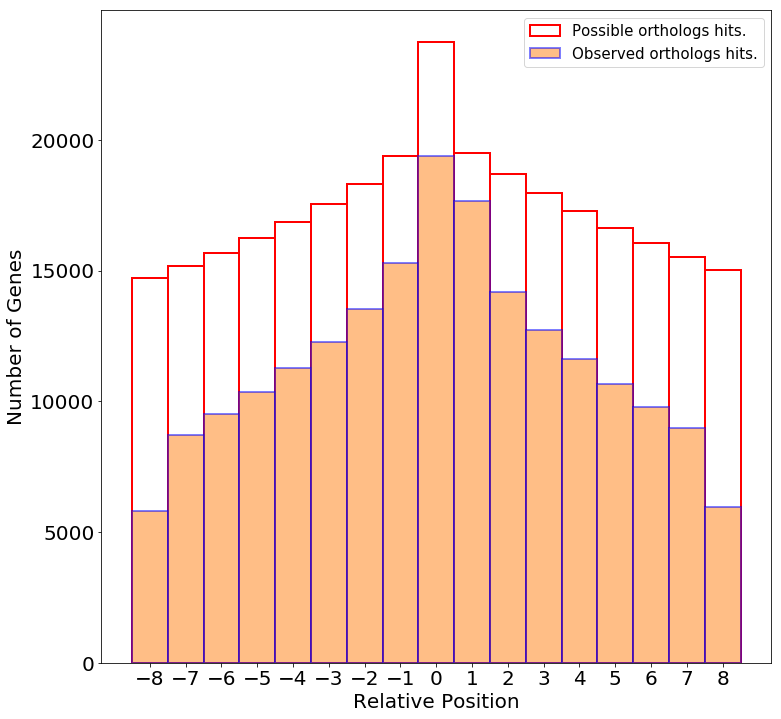

In [303]:
fig, ax = plt.subplots(figsize=(12,12))

ax.bar(x_axis_index, y_axis_possible_hit,width =1,\
       fill = False, edgecolor='r', linewidth = 2, label = 'Possible orthologs hits.')
ax.bar(x_axis_index, y_axis_hit_array, width =1,fill = True, edgecolor='b',\
       alpha = 0.5, linewidth = 2, label = 'Observed orthologs hits.' )

ax.set_xticks(x_axis_index)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={'size': 15})
ax.set_ylabel('Number of Genes', size=20)
ax.set_xlabel('Relative Position', size=20)


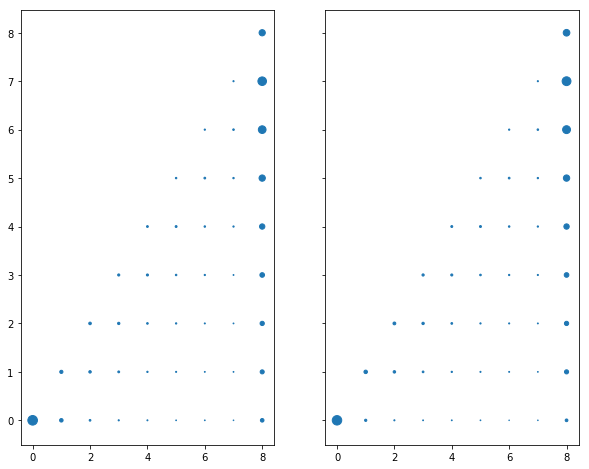

In [304]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), sharey=True)
df = up_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax2.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))
df = down_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax1.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))

In [305]:
up_match_df = up_match_df[up_match_df.index.isin(p_buscos)]
down_match_df= down_match_df[down_match_df.index.isin(p_buscos)]

In [306]:
up_hit_array = up_match_df.iloc[:,0:8].apply(lambda x: np.sum(x))
up_possible_hit_array = up_match_df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)))
down_hit_array = down_match_df.iloc[:,0:8].apply(lambda x: np.sum(x))[::-1]
down_possible_hit_array = down_match_df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)))[::-1]
x_axis_index = np.array(range(-(len(up_match_df.iloc[:,0:8].columns)),(len(up_match_df.iloc[:,0:8].columns)+1) ))


up_0_no_match = up_match_df[up_match_df['0'] != 1].index
down_0_no_match = down_match_df[down_match_df['0'] != 1].index
both_0_match = np.array(down_match_df.iloc[:,0:8].shape[0] - sum(down_match_df.iloc[:,0:8].loc[up_0_no_match, '0'] != 1))
y_axis_hit_array =  np.concatenate((down_hit_array, both_0_match, up_hit_array), axis=None)
y_axis_possible_hit = np.concatenate((down_possible_hit_array, np.array(down_match_df.shape[0]),\
                                      up_possible_hit_array), axis= None)

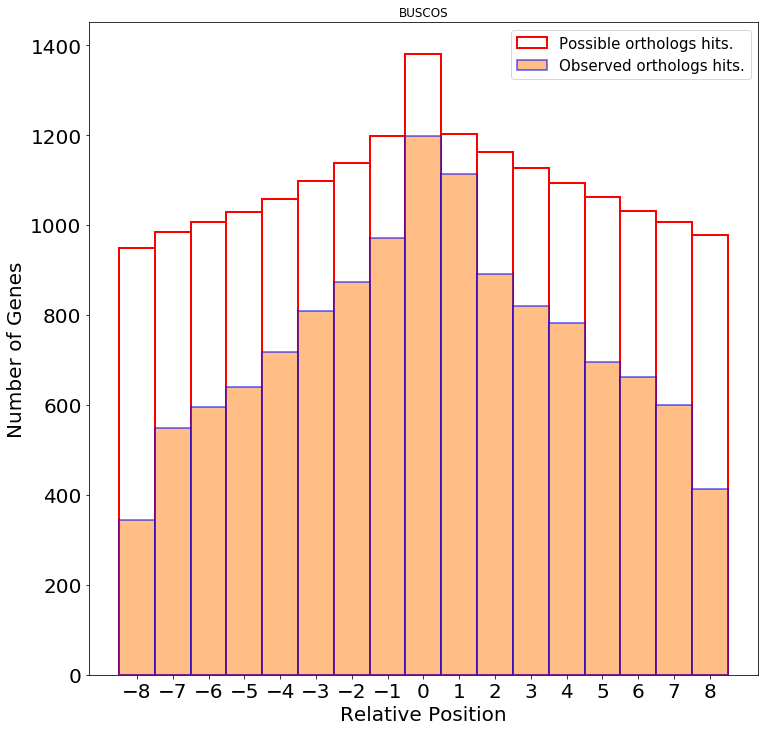

In [307]:
fig, ax = plt.subplots(figsize=(12,12))

ax.bar(x_axis_index, y_axis_possible_hit,width =1,\
       fill = False, edgecolor='r', linewidth = 2, label = 'Possible orthologs hits.')
ax.bar(x_axis_index, y_axis_hit_array, width =1,fill = True, edgecolor='b',\
       alpha = 0.5, linewidth = 2, label = 'Observed orthologs hits.' )

ax.set_xticks(x_axis_index)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={'size': 15})
ax.set_ylabel('Number of Genes', size=20)
ax.set_xlabel('Relative Position', size=20)
plt.title('BUSCOS')

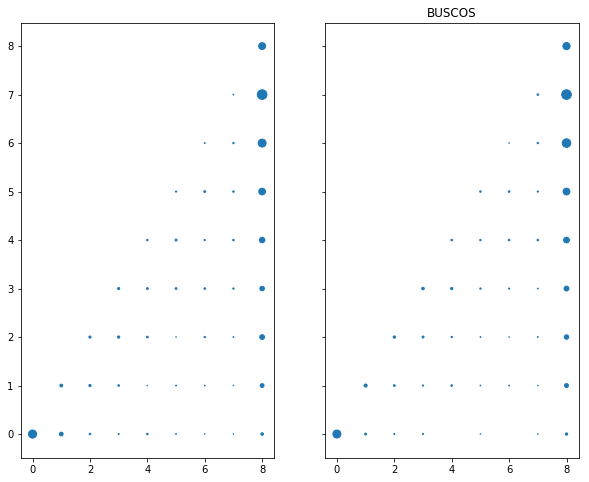

In [314]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), sharey=True)
df = up_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax2.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))
df = down_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax1.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))
plt.title('BUSCOS')

In [309]:
up_match_df = pd.read_csv(os.path.join(OUT_PATH, '20190226_up_match_simple_true_df.csv'), index_col = 0)
down_match_df = pd.read_csv(os.path.join(OUT_PATH, '20190226_down_match_simple_true_df.csv'), index_col = 0)
up_match_df = up_match_df[up_match_df.index.isin(p_effector)]
down_match_df= down_match_df[down_match_df.index.isin(p_effector)]

In [310]:
up_hit_array = up_match_df.iloc[:,0:8].apply(lambda x: np.sum(x))
up_possible_hit_array = up_match_df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)))
down_hit_array = down_match_df.iloc[:,0:8].apply(lambda x: np.sum(x))[::-1]
down_possible_hit_array = down_match_df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)))[::-1]
x_axis_index = np.array(range(-(len(up_match_df.iloc[:,0:8].columns)),(len(up_match_df.iloc[:,0:8].columns)+1) ))


up_0_no_match = up_match_df[up_match_df['0'] != 1].index
down_0_no_match = down_match_df[down_match_df['0'] != 1].index
both_0_match = np.array(down_match_df.iloc[:,0:8].shape[0] - sum(down_match_df.iloc[:,0:8].loc[up_0_no_match, '0'] != 1))
y_axis_hit_array =  np.concatenate((down_hit_array, both_0_match, up_hit_array), axis=None)
y_axis_possible_hit = np.concatenate((down_possible_hit_array, np.array(down_match_df.shape[0]),\
                                      up_possible_hit_array), axis= None)

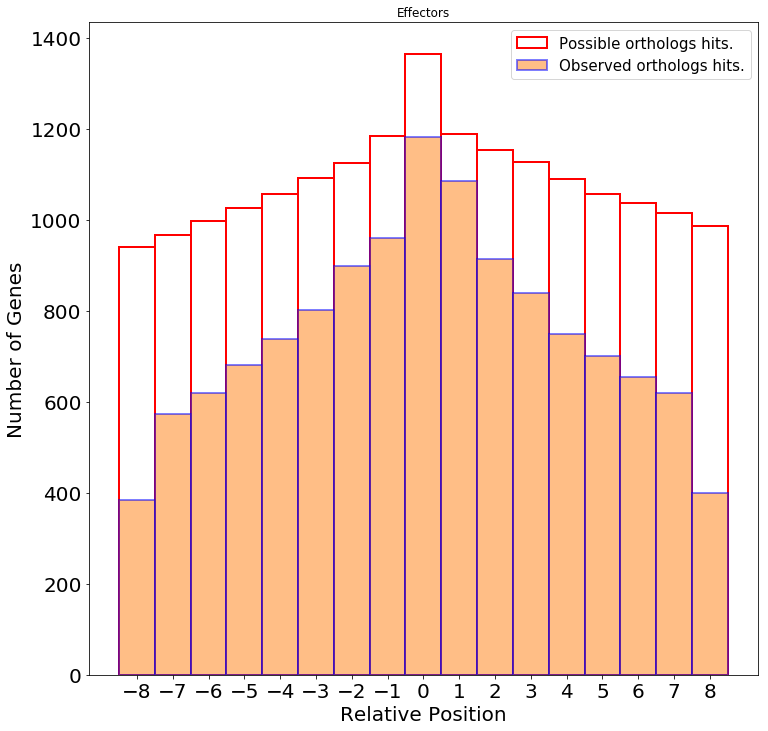

In [311]:
fig, ax = plt.subplots(figsize=(12,12))

ax.bar(x_axis_index, y_axis_possible_hit,width =1,\
       fill = False, edgecolor='r', linewidth = 2, label = 'Possible orthologs hits.')
ax.bar(x_axis_index, y_axis_hit_array, width =1,fill = True, edgecolor='b',\
       alpha = 0.5, linewidth = 2, label = 'Observed orthologs hits.' )

ax.set_xticks(x_axis_index)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(prop={'size': 15})
ax.set_ylabel('Number of Genes', size=20)
ax.set_xlabel('Relative Position', size=20)
plt.title('Effectors')

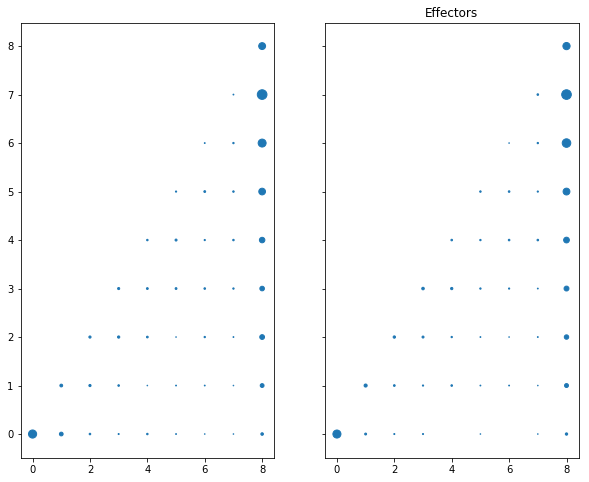

In [313]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), sharey=True)
df = up_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax2.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))
df = down_match_df
df['potential_hits'] = df.iloc[:,0:8].apply(lambda x: np.count_nonzero(~np.isnan(x)), axis =1)
df['observed_hits'] = df.iloc[:,0:8].apply(lambda x: np.sum(x), axis=1)
x_range = list(range(0,9))
x_cords = []
y_cords = []
sizes = []
for x in x_range :
    for y in x_range:
        x_cords.append(x)
        y_cords.append(y)
        sizes.append(df[(df['observed_hits'] == y) & (df['potential_hits'] == x)].shape[0])
ax1.scatter(x_cords, y_cords,s=([x/sum(sizes)*500 for x in sizes]))
plt.title('Effectors')